# Setup

**Imports**

In [1]:
import datetime as dt
import itertools
from math import asin, cos, log, radians, sin, sqrt

import contextily as cx
import geopandas
import IPython
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from pygsp import graphs
from scipy.fft import fft
from scipy.linalg import eigh
from scipy.signal import ShortTimeFFT, medfilt, windows
from scipy.signal.windows import hann
from scipy.spatial.distance import pdist, squareform
import scipy.sparse as sp
from scipy import stats
from tqdm import tqdm
import re

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [2]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [3]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))

D 6 A 8 3 D 1 8 B 9


In [4]:
DTMF_MAP = {
    (697, 1209): "1", (697, 1336): "2", (697, 1477): "3", (697, 1633): "A",
    (770, 1209): "4", (770, 1336): "5", (770, 1477): "6", (770, 1633): "B",
    (852, 1209): "7", (852, 1336): "8", (852, 1477): "9", (852, 1633): "C",
    (941, 1209): "*", (941, 1336): "0", (941, 1477): "#", (941, 1633): "D",
}
DTMF_LOW  = np.array([697, 770, 852, 941], dtype=float)
DTMF_HIGH = np.array([1209, 1336, 1477, 1633], dtype=float)
FS = 22.05e3

def decode_dtmf(signal, fs=22050, window=512, nfft=4096, pen=0.1, model='l2', SILENT_THRESHOLD=0.1):
    # (Ensure you use 'fs' lowercase here to avoid that TypeError)
    x = np.asarray(signal, dtype=float)
    if x.size == 0: return []
    
    win = hann(window)
    sfft = ShortTimeFFT(win, window//4, fs=fs, fft_mode="onesided", mfft=nfft)
    f = sfft.f
    Zxx = sfft.stft(x)
    P = np.abs(Zxx)**2 

    frame_energy = P.sum(axis=0)
    if frame_energy.max() > 0:
        frame_energy /= frame_energy.max()
    smoothed_energy = medfilt(frame_energy, kernel_size=3)

    try:
        algo = rpt.Pelt(model=model).fit(smoothed_energy)
        cps = [0] + algo.predict(pen=pen)
    except:
        return []

    symbols = []
    low_mask = (f >= 650) & (f <= 1000)
    high_mask = (f >= 1150) & (f <= 1700)

    for i in range(len(cps) - 1):
        start, end = cps[i], cps[i+1]
        if (end - start) < 3: continue 
        
        seg_p = P[:, start:end]
        # Check if this segment is loud enough to be a symbol
        if frame_energy[start:end].mean() < SILENT_THRESHOLD:
            continue

        mean_spec = seg_p.mean(axis=1)
        
        # Identification
        f_low = f[low_mask][np.argmax(mean_spec[low_mask])]
        f_high = f[high_mask][np.argmax(mean_spec[high_mask])]

        f_l_q = DTMF_LOW[np.argmin(np.abs(DTMF_LOW - f_low))]
        f_h_q = DTMF_HIGH[np.argmin(np.abs(DTMF_HIGH - f_high))]

        sym = DTMF_MAP.get((int(f_l_q), int(f_h_q)))
        if sym:
            # deduplicate back-to-back identical symbols from over-segmentation
            if not symbols or symbols[-1] != sym:
                symbols.append(sym)
    return symbols

In [5]:

# Parameters to fix your specific errors (Ghosts and Misclassifications)
param_grid = {
    'pen': [0.1, 0.5, 1.0, 2.0],
    'SILENT_THRESHOLD': [0.5, 0.6, 0.7], 
    'window': [512, 1024]                
}

def run_final_search(X, y, FS=22050):
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    best_error = float('inf')
    best_params = None

    for params in tqdm(combinations, desc="Searching for best fit"):
        # We use nfft=4096 and model='l2' as fixed since they work well
        y_pred = [decode_dtmf(x, fs=FS, nfft=4096, model='l2', **params) for x in X]
        
        # Mean Levenshtein Distance
        distances = [
            Levenshtein.distance("".join(y_t), "".join(y_p))
            for y_t, y_p in zip(y, y_pred)
        ]
        avg_error = np.mean(distances)
        
        if avg_error < best_error:
            best_error = avg_error
            best_params = params
            
    print("\nOptimization Complete.")
    print(f"Best Avg Distance: {best_error:.4f}")
    print(f"Best Parameters: {best_params}")
    return best_params

# Run it
# best_config = run_final_search(X_train, y_train)

# Question 2

In [6]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

In [7]:
print("".join(decode_dtmf(X_test[0])))
print("".join(decode_dtmf(X_test[1])))

51C9*
#*17#126#1


# Question 3

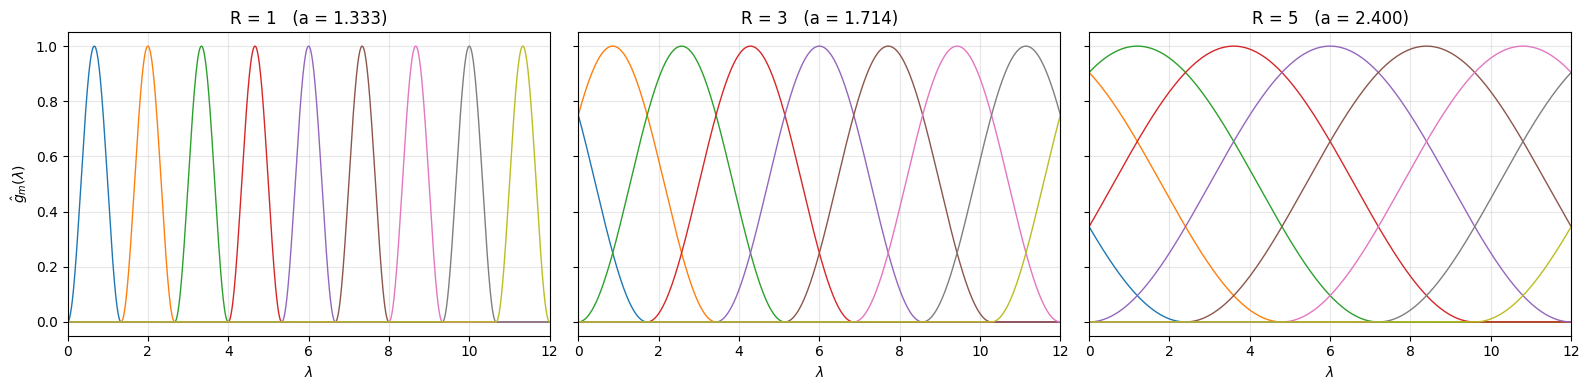

In [8]:
# ---- Params ----
M = 9
lambda_n = 12.0
Rs = [1, 3, 5]

# grid on [0, lambda_n]
lam = np.linspace(0.0, lambda_n, 2000)

def gU(x, a, R):
    """
    x is the shifted argument (lambda - a_m).
    Definition: gU(x) = 1/2 [1 + cos(2π( x/(aR) + 1/2 ))] * 1_{-Ra <= x < 0}
    """
    y = np.zeros_like(x)
    mask = (x >= -R * a) & (x < 0.0)
    y[mask] = 0.5 * (1.0 + np.cos(2.0 * np.pi * (x[mask] / (a * R) + 0.5)))
    return y

def gm(lam, m, a, R):
    a_m = m * a  # shift location
    return gU(lam - a_m, a, R)

# ---- Plot ----
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, R in zip(axes, Rs):
    a = lambda_n / (M + 1 - R)
    for m in range(1, M + 1):
        ax.plot(lam, gm(lam, m, a, R), lw=1)
    ax.set_title(f"R = {R}   (a = {a:.3f})")
    ax.set_xlim(0, lambda_n)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel(r"$\lambda$")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel(r"$\hat g_m(\lambda)$")
plt.tight_layout()
plt.savefig("figures/sagw_kernels.png")

# Question 4

## Utility functions: 

In [9]:
def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r    

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def is_connected(graph) -> bool:
    return graph.is_connected()

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [10]:
data_df, stations_df, description = load_molene_meteo_dataset()

In [11]:
data_df["temp"] = data_df['t']- 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


In [12]:
print("Total Stations", len(stations_df))
print("Number of Stations with Nans" , (~temperature_df.notna().all()).sum())
print("Stations with Nans", temperature_df.columns[~temperature_df.notna().all()])

Total Stations 55
Number of Stations with Nans 18
Stations with Nans Index(['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET',
       'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA',
       'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN',
       'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON'],
      dtype='object', name='station_name')


In [13]:
valid_stations = temperature_df.columns[temperature_df.notna().all()]
temperature_df = temperature_df[valid_stations]
stations_df = stations_df[stations_df["Nom"].isin(valid_stations)]
stations_df = stations_df.reset_index(drop=True)

print("Valid Stations", len(stations_df))

Valid Stations 37


In [14]:
stations = stations_df.set_index("Nom")
stations = stations.loc[temperature_df.columns]

In [15]:
coords = stations[["X (Lambert II étendu)", "Y (Lambert II étendu)"]].values
# condensed distance matrix
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
distances = pdist(stations_np, metric=get_geodesic_distance)

bandwidth = np.median(distances)

In [16]:
def build_graph(similarites):
    W = squareform(similarites)
    np.fill_diagonal(W,0)
    return graphs.Graph(W)

In [17]:
thresholds = np.linspace(0.99, 0.0, 400)
for t in thresholds:
    similarities = get_exponential_similarity(distances, bandwidth, t)
    graph = build_graph(similarities)
    if graph.is_connected() and graph.d.mean() > 3:
        selected_threshold = t
        break

print("Minimum threshold ", selected_threshold)

Minimum threshold  0.8312030075187969


In [18]:
similarities = get_exponential_similarity(
    condensed_distance_matrix=distances,
    bandwidth=bandwidth,
    threshold=selected_threshold,
)

G = build_graph(similarities)
G.compute_laplacian()


In [19]:
X = temperature_df.to_numpy(dtype=float) 
dates = temperature_df.index  

E = np.einsum("ti,ij,tj->t", X, G.L.toarray(), X)

In [20]:
t_least = np.argmax(E)
date_least = dates[t_least]
energy_least = E[t_least]
t_smooth = np.argmin(E)
date_smooth = dates[t_smooth]
energy_smooth = E[t_smooth]


In [21]:
print(f"Least smooth signal occurs at {date_least} (E = {energy_least:.2f})")
print(f"Smoothest signal occurs at {date_smooth} (E = {energy_smooth:.2f})")


Least smooth signal occurs at 2014-01-10 09:00:00 (E = 1536.01)
Smoothest signal occurs at 2014-01-24 19:00:00 (E = 24.39)


# Question 5: Node frequency classification

In [22]:
# Parameters
R = 3
M = 9

In [23]:
def compute_W(f, graph, R=3, M=9):
    """
    Computes W, the Graph Wavelet Transform (GWT) of signal f.

    Args:
        f (array): signal of length N.
        graph (graph): set of n nodes V and a set of edges E.
        R (int, optional): > 0. Defaults to 3.
        M (int, optional): Number of scales. Defaults to 9.

    Returns:
        array: GWT coefficients W of shape (M, N).
    """
    eigenvals, eigenvecs = eigh(graph.L.todense())
    W = np.zeros((M, len(eigenvecs)))
    g = np.stack([gm(eigenvals, m, lambda_n / (M + 1 - R), R) for m in range(1, M + 1)])

    f_hat = f.T @ eigenvecs
    for idx, v in enumerate(eigenvecs):
        ul_v = eigenvecs[idx, :][None, :]
        w = g * f_hat[None, :] * ul_v
        W[:, idx] = np.sum(w, axis=1)
    
    return W


def classify_nodes(W):
    """
    Classify each node based on the energy in low, mid, and high frequency bands.

    Args:
        W (array): GWT coefficients W of shape (M, N).

    Returns:
        array: class indices for each node.
                0: low frequency dominant
                1: mid frequency dominant
                2: high frequency dominant
    """
    low_freq_class = np.sum(np.abs(W[0:3, :]), axis=0)
    mid_freq_class = np.sum(np.abs(W[3:6, :]), axis=0)
    high_freq_class = np.sum(np.abs(W[6:9, :]), axis=0)

    energy = np.stack([low_freq_class, mid_freq_class, high_freq_class])
    class_idx = np.argmax(energy, axis=0)
    return class_idx

In [24]:
# Compute W for the three signals
W_first = compute_W(temperature_df.iloc[0], G, R=R, M=M)
W_smoothest = compute_W(temperature_df.iloc[t_smooth], G, R=R, M=M)
W_least_smooth = compute_W(temperature_df.iloc[t_least], G, R=R, M=M)

# Classify nodes
class_first = classify_nodes(W_first)
class_smoothest = classify_nodes(W_smoothest)
class_least_smooth = classify_nodes(W_least_smooth)

In [25]:
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(stations_df.Longitude, stations_df.Latitude),
).set_crs("EPSG:4326")

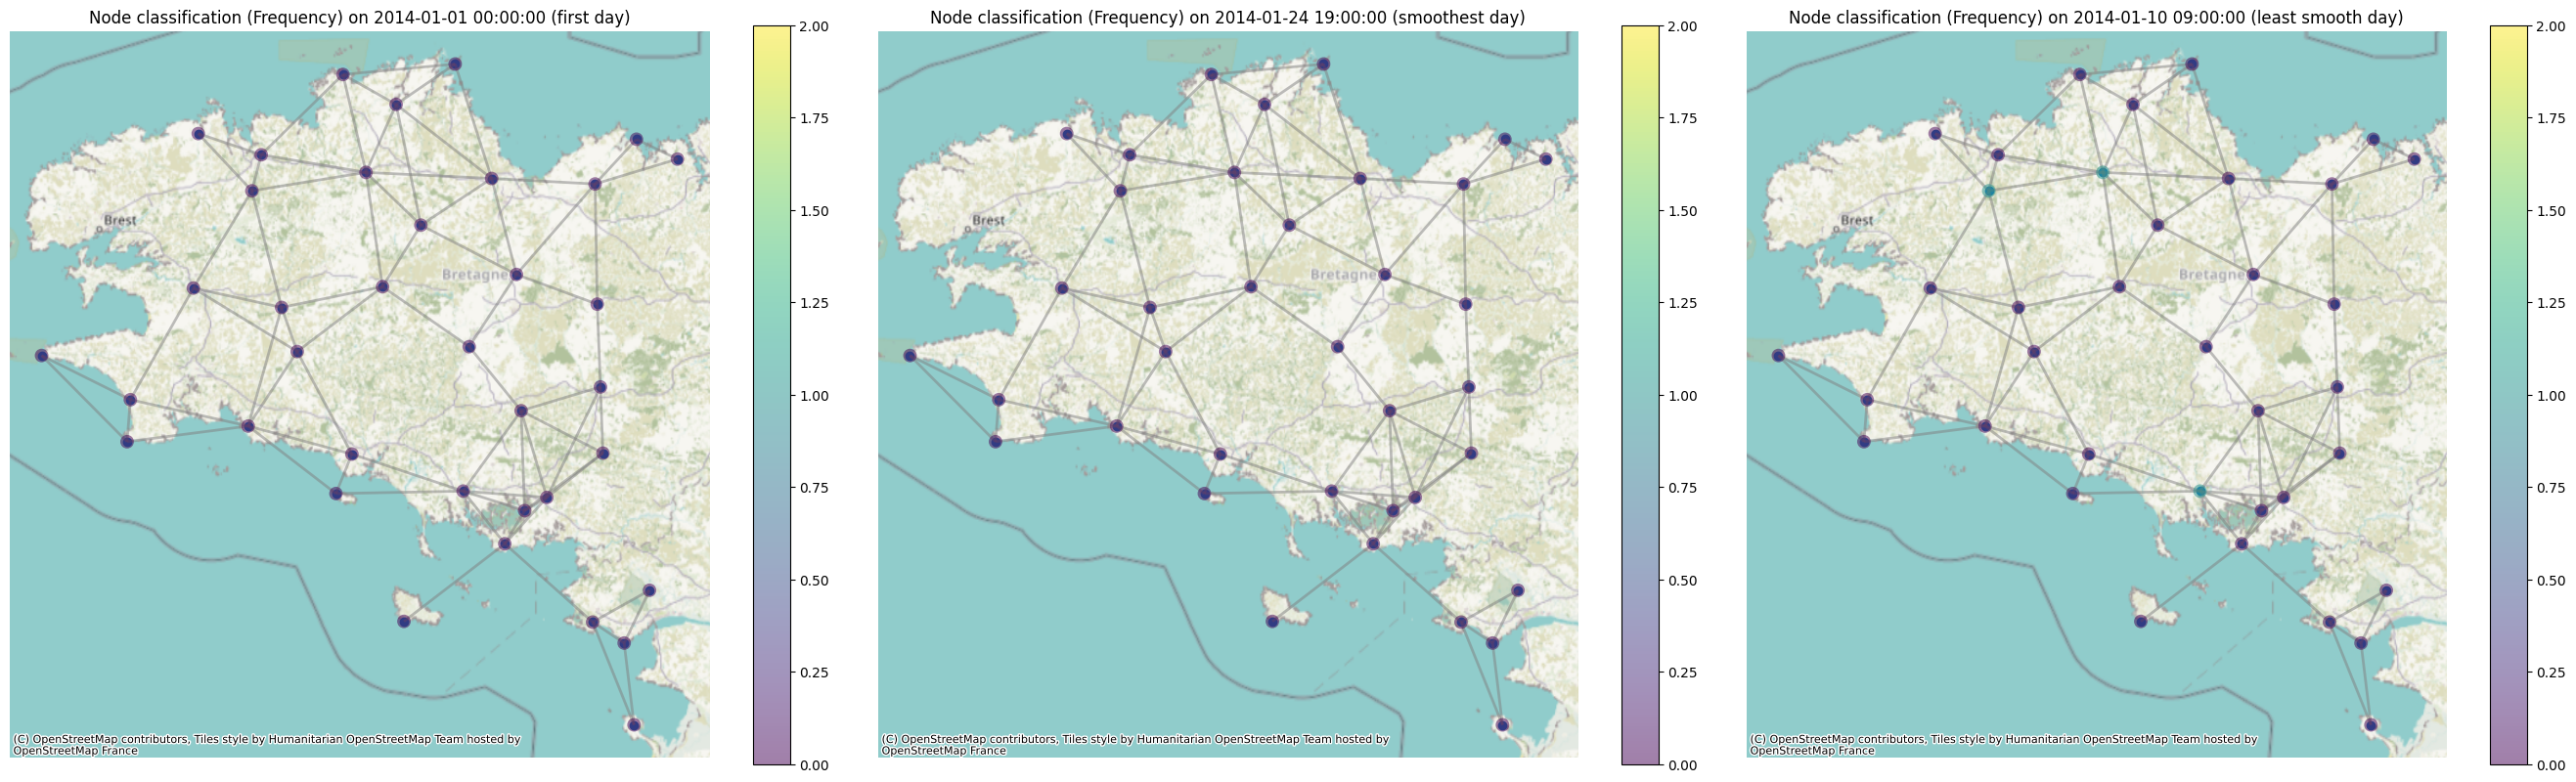

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(27, 8))

for idx, (day, W) in enumerate({
    f"{temperature_df.index[0]} (first day)": class_first,
    f"{date_smooth} (smoothest day)": class_smoothest,
    f"{date_least} (least smooth day)": class_least_smooth,
}.items()):
    ax = axes[idx]
    ax = stations_gdf.geometry.plot(ax=ax, figsize=(8, 8))
    
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    
    graph.set_coordinates(stations_np)
    graph.plot_signal(W, ax=ax, limits=[0, 2]) # classes are 0, 1, 2

    ax.set_axis_off()
    ax.set_title(f"Node classification (Frequency) on {day}")

plt.tight_layout()

# Question 6: Average temperature

In [27]:
marker = []
for t in range(len(temperature_df)):
    W_t = compute_W(temperature_df.iloc[t], G, R=R, M=M)
    class_t = classify_nodes(W_t)

    values, counts = np.unique(class_t, return_counts=True)
    majority_class = values[np.argmax(counts)]
    marker.append(majority_class)

marker = np.array(marker)

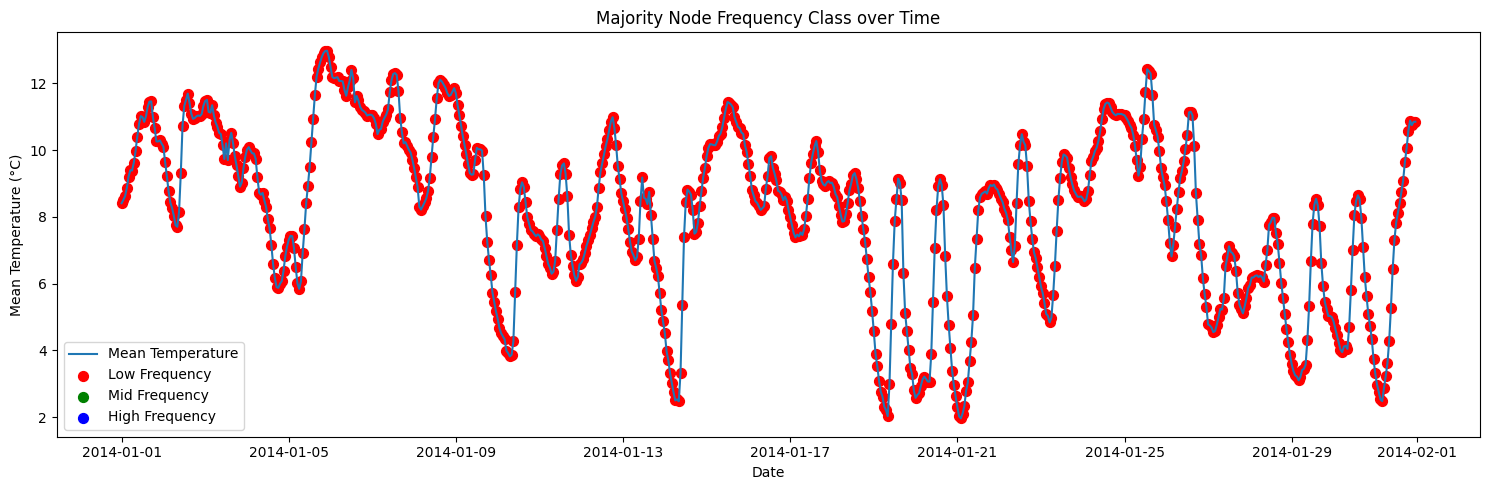

In [28]:
fig = plt.figure(figsize=(15, 5))

plt.plot(temperature_df.index, temperature_df.T.mean(), label="Mean Temperature")

marker_list = ["o", "s", "^"]
color_list = ["red", "green", "blue"]
freq_dict = {0: "Low", 1: "Mid", 2: "High"}

for mark in [0, 1, 2]:
    marker_dates = temperature_df.index[marker == mark]
    marker_values = np.array(temperature_df.T.mean())[marker == mark]
    plt.scatter(marker_dates, marker_values, label=f"{freq_dict[mark]} Frequency", color=color_list[mark], s=50)

plt.title("Majority Node Frequency Class over Time")
plt.xlabel("Date")
plt.ylabel("Mean Temperature (°C)")
plt.legend()
plt.tight_layout()

plt.savefig("figures/average_temperature_markers.png")
plt.show()


# Question 7: Spatio-temporal graph

In [29]:
X_raw = temperature_df.values.T
X = (X_raw - X_raw.mean()) / X_raw.std()

N, T = X.shape

In [30]:
# Eigendecomposition
# Spatial Graph G
evals_G, U_G = np.linalg.eigh(G.L.todense())

# Temporal Graph G'
diagonals = [np.ones(T-1), np.ones(T-1)]
offsets = [-1, 1]
A = sp.diags(diagonals, offsets, shape=(T, T))

degrees = np.array(A.sum(axis=1)).flatten()
D = sp.diags(degrees)

L_temporal = D - A

evals_GT, U_GT = np.linalg.eigh(L_temporal.todense())

In [31]:
# Spatio-Temporal eigenvalues
evals_H_grid = evals_G[:, None] + evals_GT[None, :]

# Spatio-Temporal Wavelet Transform
X_hat = U_G.T @ X @ U_GT

lambda_n = np.max(evals_H_grid.flatten())
a = lambda_n / (M + 1 - R)
    
kernels = []
for m in range(1, M + 1):
    g_val = gU(evals_H_grid.flatten() - a * m, a, R)
    kernels.append(g_val)

kernels = np.array(kernels) 
kernels_grid = kernels.reshape(M, N, T)

X_hat = np.asarray(X_hat)
coeffs = np.zeros((M, N, T))
for m in range(M):
    X_hat_filtered = X_hat * kernels_grid[m]
    coeffs[m] = U_G @ X_hat_filtered @ U_GT.T


In [32]:
energy = coeffs ** 2

# We have to normalize the bands by their baseline energy in order to find relative changes.
band_baselines = np.mean(energy, axis=(1, 2))
energy_normalized = energy / (band_baselines[:, None, None] + 1e-10)

E_low  = np.sum(energy_normalized[0:3], axis=0)
E_mid  = np.sum(energy_normalized[3:6], axis=0)
E_high = np.sum(energy_normalized[6:9], axis=0)

classes = np.argmax([E_low, E_mid, E_high], axis=0)

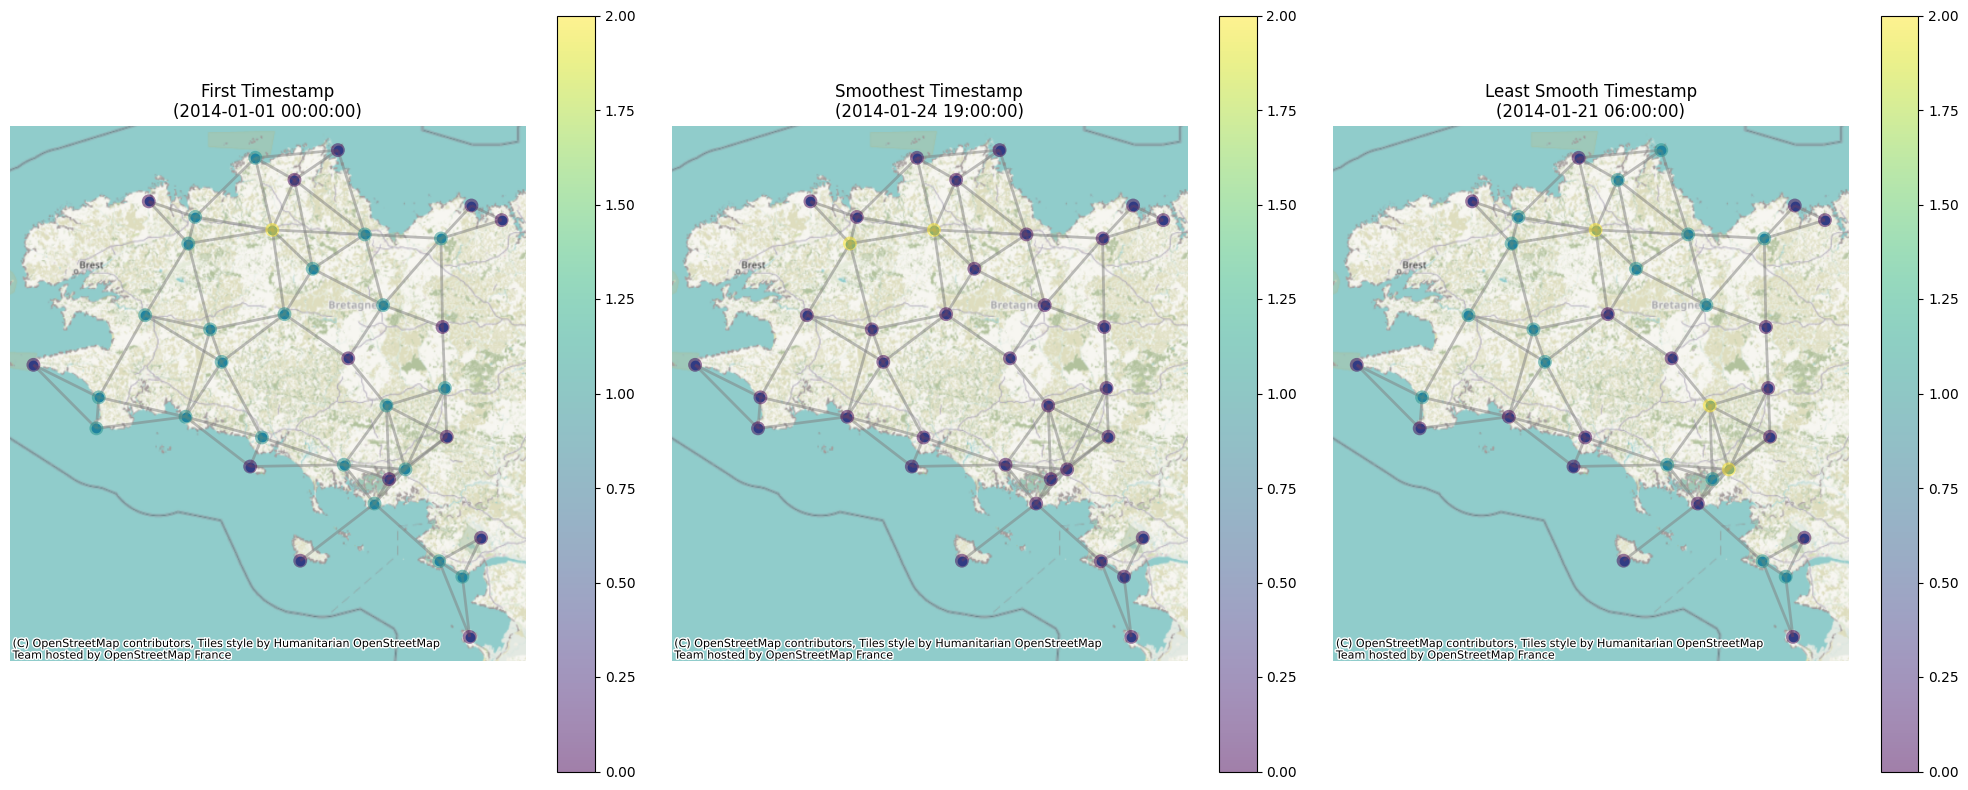

In [33]:
t_least_smooth = "2014-01-21 06:00:00"
t_smoothest = "2014-01-24 19:00:00"
t_first = temperature_df.index[0]

# Mapping Titles to Timestamps
timestamps_to_plot = {
    "First Timestamp": t_first,
    "Smoothest Timestamp": t_smoothest,
    "Least Smooth Timestamp": t_least_smooth
}

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

graph.set_coordinates(stations_np)

for idx, (title, ts_str) in enumerate(timestamps_to_plot.items()):
    ax = axes[idx]
    
    t_idx = temperature_df.index.get_loc(ts_str)
        
    signal_to_plot = classes[:, t_idx]
    stations_gdf.plot(ax=ax)
    
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)    
    graph.plot_signal(signal_to_plot, ax=ax, limits=[0, 2], title=f"{title}\n({ts_str})")

    ax.set_axis_off()

plt.tight_layout()
plt.show()

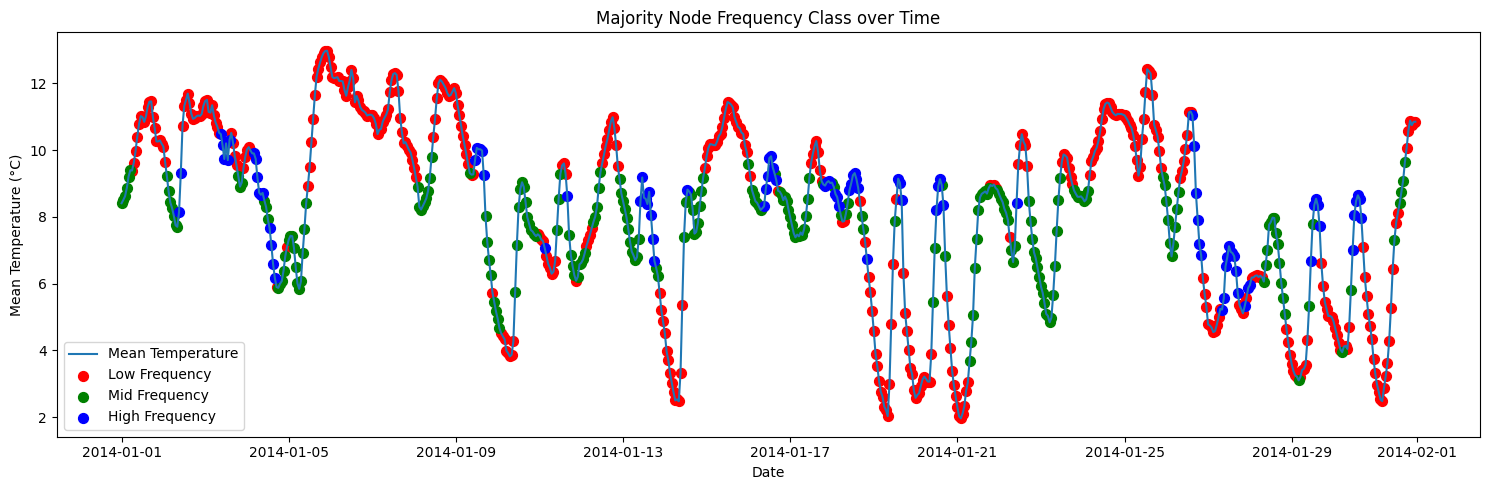

In [ ]:
marker = stats.mode(classes, axis=0)[0].flatten()

fig = plt.figure(figsize=(15, 5))

plt.plot(temperature_df.index, temperature_df.T.mean(), label="Mean Temperature")

marker_list = ["o", "s", "^"]
color_list = ["red", "green", "blue"]
freq_dict = {0: "Low", 1: "Mid", 2: "High"}

for mark in [0, 1, 2]:
    marker_dates = temperature_df.index[marker == mark]
    marker_values = np.array(temperature_df.T.mean())[marker == mark]
    plt.scatter(marker_dates, marker_values, label=f"{freq_dict[mark]} Frequency", color=color_list[mark], s=50)

plt.title("Majority Node Frequency Class over Time")
plt.xlabel("Date")
plt.ylabel("Mean Temperature (°C)")
plt.legend()
plt.tight_layout()

plt.show()